<a href="https://colab.research.google.com/github/XueqingWu/Explainable_Deep_Learning/blob/main/Explainable_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explainable Deep Learning

## Hypothesis Testing
H0: The GoogleNet model does not show a significant difference in its ability to learn the concept "striped" compared to the concept "dotted" for the class ‘cheetah’.



H1: The GoogleNet model shows a significant difference in its ability to learn the concept "striped" compared to the concept "dotted" for the class ‘cheetah’, specifically, it learns the concept "dotted" but not the concept "striped" or "zigzagged".

## Experiement--Testing Concept Activation Vectors (TCAV)
Testing Concept Actication Vectors method is used here to test for the hypothesis.

### Import Github Repo and Packages

In [1]:

# We are going to clone the tcav repo in GitHub:
# !git clone https://github.com/tensorflow/tcav.git tcav

!git clone https://github.com/XueqingWu/tcav tcav

%cd tcav
!ls

# Next, we will create the datasets
%cd /content/tcav/tcav/tcav_examples/image_models/imagenet
%run download_and_make_datasets.py --source_dir=YOUR_FOLDER --number_of_images_per_folder=10 --number_of_random_folders=10

%cd /content/tcav

Cloning into 'tcav'...
remote: Enumerating objects: 661, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 661 (delta 0), reused 2 (delta 0), pack-reused 653 (from 1)
Receiving objects: 100% (661/661), 615.11 KiB | 16.62 MiB/s, done.
Resolving deltas: 100% (375/375), done.
/content/tcav
CONTRIBUTING.md        LICENSE	  requirements.txt  Run_TCAV_on_colab.ipynb  tcav
FetchDataAndModels.sh  README.md  Run_TCAV.ipynb    setup.py
/content/tcav/tcav/tcav_examples/image_models/imagenet
Created source directory at YOUR_FOLDER
Downloaded 10 for cheetah
Successfully created data at YOUR_FOLDER
/content/tcav


In [2]:

# Basic
import os
import absl
import random
import matplotlib.pyplot as plt
from PIL import Image

# Models
import tensorflow as tf

#XAI
import tcav.activation_generator as act_gen
import tcav.cav as cav
import tcav.model  as model
import tcav.tcav as tcav
import tcav.utils as utils
import tcav.utils_plot as utils_plot

### Create and Store Image Data

The data used here is imported from ImageNet. The data download and creation process is updated in https://github.com/XueqingWu/tcav/blob/master/tcav/tcav_examples/image_models/imagenet/download_and_make_datasets.py

In [4]:

# Model wrapper (InceptionV3 and GoogleNet are provided in model.py)
model_to_run = 'GoogleNet'
# Name of the parent directory that results are stored (if cacheing)
project_name = 'tcav_class_test'
working_dir = '/content/tcav/tcav'
# Location where activations are stored
activation_dir =  working_dir+ '/activations/'
# Location where CAVs are stored (or None if not storing)
cav_dir = working_dir + '/cavs/'
# Location of images
source_dir = '/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER'
# Bottleneck layer
bottlenecks = ['mixed4c']

# Create directories if they don't exist
utils.make_dir_if_not_exists(activation_dir)
utils.make_dir_if_not_exists(working_dir)
utils.make_dir_if_not_exists(cav_dir)

# Regularizer penalty parameter for linear classifier to get CAVs
alphas = [0.1]

target = 'cheetah'
concepts = ["dotted","striped","zigzagged"]

In [5]:
%cp -av '/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER/mobilenet_v2_1.0_224' '/content/tcav/tcav/mobilenet_v2_1.0_224'
%rm '/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER/mobilenet_v2_1.0_224'

'/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER/mobilenet_v2_1.0_224' -> '/content/tcav/tcav/mobilenet_v2_1.0_224'
'/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER/mobilenet_v2_1.0_224/mobilenet_v2_1.0_224_eval.pbtxt' -> '/content/tcav/tcav/mobilenet_v2_1.0_224/mobilenet_v2_1.0_224_eval.pbtxt'
'/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER/mobilenet_v2_1.0_224/mobilenet_v2_1.0_224.ckpt.data-00000-of-00001' -> '/content/tcav/tcav/mobilenet_v2_1.0_224/mobilenet_v2_1.0_224.ckpt.data-00000-of-00001'
'/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER/mobilenet_v2_1.0_224/mobilenet_v2_1.0_224_frozen.pb' -> '/content/tcav/tcav/mobilenet_v2_1.0_224/mobilenet_v2_1.0_224_frozen.pb'
'/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER/mobilenet_v2_1.0_224/mobilenet_v2_1.0_224.tflite' -> '/content/tcav/tcav/mobilenet_v2_1.0_224/mobilenet_v2_1.0_224.tflite'
'/content/tcav/tcav/tcav_examples/image_models/imag

In [6]:

%cp -av '/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER/inception5h' '/content/tcav/tcav/inception5h'
%rm '/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER/inception5h'

'/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER/inception5h' -> '/content/tcav/tcav/inception5h'
'/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER/inception5h/imagenet_comp_graph_label_strings.txt' -> '/content/tcav/tcav/inception5h/imagenet_comp_graph_label_strings.txt'
'/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER/inception5h/tensorflow_inception_graph.pb' -> '/content/tcav/tcav/inception5h/tensorflow_inception_graph.pb'
'/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER/inception5h/LICENSE' -> '/content/tcav/tcav/inception5h/LICENSE'
rm: cannot remove '/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER/inception5h': Is a directory


### Visualize Images from the Target, Concepts, and Random folders

Images from target folder:


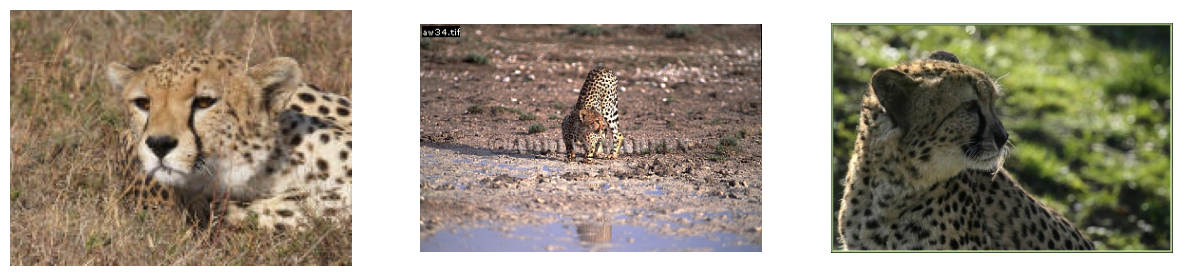

Images from dotted folder:


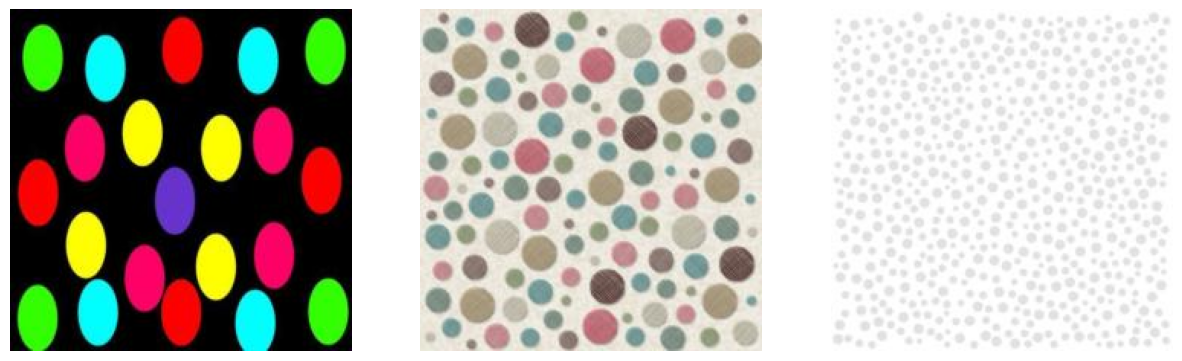

Images from striped folder:


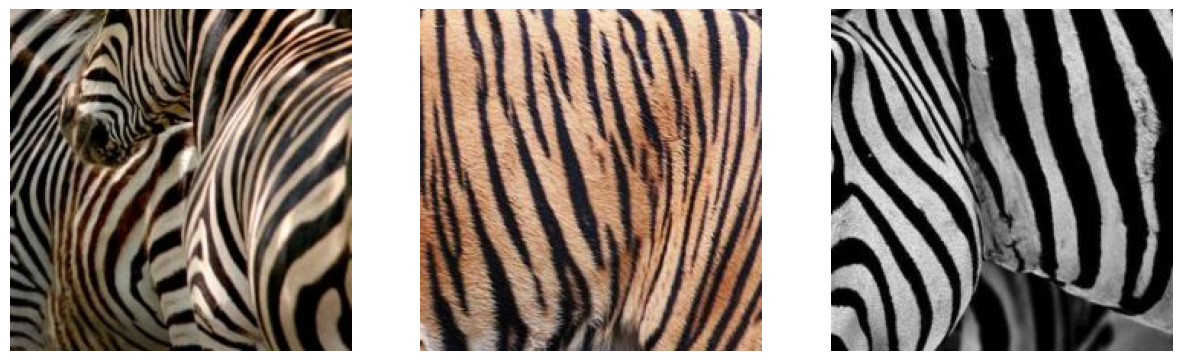

Images from zigzagged folder:


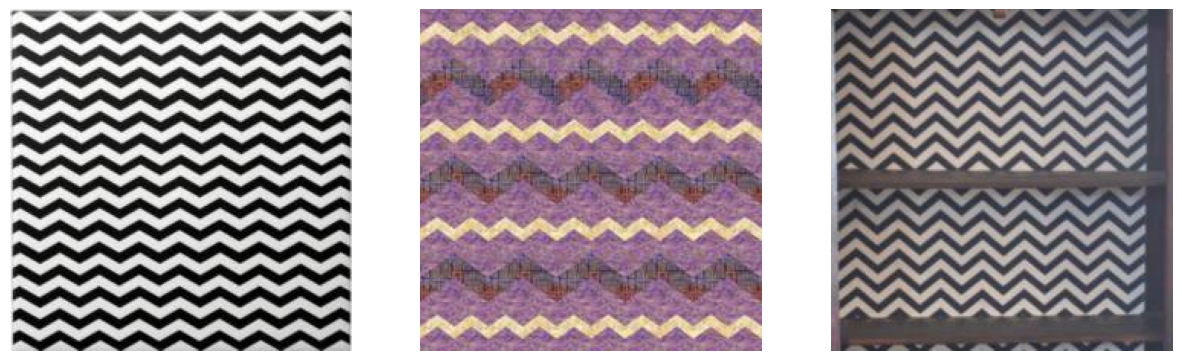

Images from random folder:


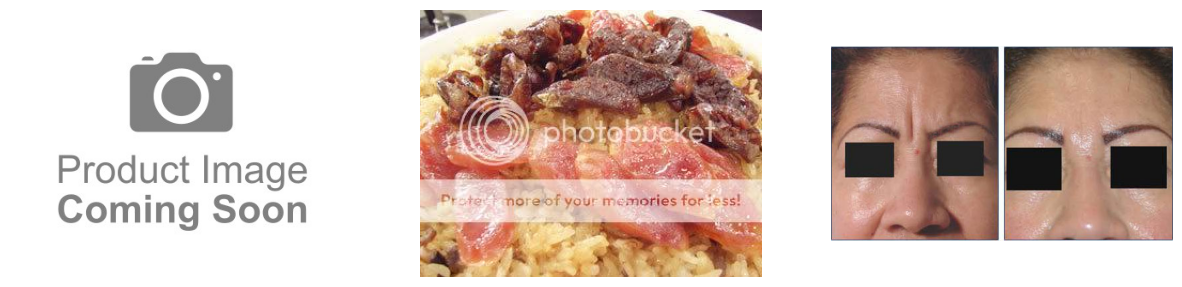

In [7]:

def display_random_images(directory, num_images):
    # Get list of files in the directory
    files = os.listdir(directory)

    # Filter out non-image files
    image_files = [f for f in files if f.endswith('.jpg')]

    # Check if there are enough image files
    if len(image_files) < num_images:
        print(f"Not enough images in {directory}.")
        return

    # Select random images
    random_images = random.sample(image_files, num_images)

    # Display selected images
    fig, axs = plt.subplots(1, num_images, figsize=(15, 5))
    for i, image_file in enumerate(random_images):
        image_path = os.path.join(directory, image_file)
        image = Image.open(image_path)
        axs[i].imshow(image)
        axs[i].axis('off')
    plt.show()

# Define source directory
source_dir = '/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER'
target = 'cheetah'
concepts = ["dotted","striped","zigzagged"]
random_folder = 'random500_10'

# Display 3 images from the target folder in a row
print("Images from target folder:")
# display_random_images(os.path.join(source_dir, target), 3)
display_random_images(os.path.join(source_dir, target ), 3)

# Display 3 images from each concept folder
for concept in concepts:
    print(f"Images from {concept} folder:")
    display_random_images(os.path.join(source_dir, concept), 3)

# Display 3 images from a random folder
print("Images from random folder:")
display_random_images(os.path.join(source_dir, random_folder), 3)

### Model Wrapper

In [8]:

sess = utils.create_session() # a tensorflow session

GRAPH_PATH = "/content/tcav/tcav/inception5h/tensorflow_inception_graph.pb"
LABEL_PATH = "/content/tcav/tcav/inception5h/imagenet_comp_graph_label_strings.txt"

mymodel = model.GoogleNetWrapper_public(sess,
                                        GRAPH_PATH,
                                        LABEL_PATH)

### Return Actications

In [9]:
act_generator = act_gen.ImageActivationGenerator(mymodel, source_dir, activation_dir, max_examples=100)


### Run TCAV

In [10]:

absl.logging.set_verbosity(0)
num_random_exp=10 # Recommend >10
mytcav = tcav.TCAV(sess,
                   target,
                   concepts,
                   bottlenecks,
                   act_generator,
                   alphas,
                   cav_dir=cav_dir,
                   num_random_exp=num_random_exp)#10)
print ('Started')
results = mytcav.run(run_parallel=False)
print ('Completed')

Started
Completed


### Plot Bar Plot Results

Class = cheetah
  Concept = dotted
    Bottleneck = mixed4c. TCAV Score = 0.81 (+- 0.21), random was 0.47 (+- 0.28). p-val = 0.000 (significant)
  Concept = striped
    Bottleneck = mixed4c. TCAV Score = 0.47 (+- 0.23), random was 0.47 (+- 0.28). p-val = 0.937 (not significant)
  Concept = zigzagged
    Bottleneck = mixed4c. TCAV Score = 0.58 (+- 0.25), random was 0.47 (+- 0.28). p-val = 0.273 (not significant)
{'mixed4c': {'bn_vals': [0.8111111111111111, 0.01, 0.01], 'bn_stds': [0.2051798368068821, 0, 0], 'significant': [True, False, False]}}


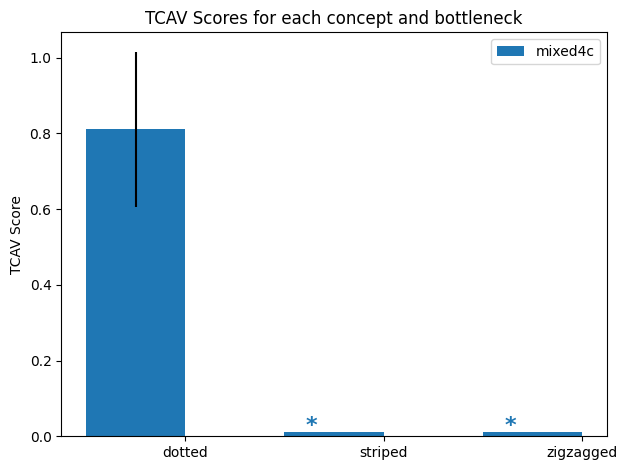

In [11]:

utils_plot.plot_results(results, num_random_exp=num_random_exp)

The TCAV score for dotted is about 0.8, which is statistically significant, whereas TCAV score for striped and zigzagged pattern is quite low.

## Test Results
According to the barplot and the statistical testing result, dotted pattern is statistically significant for identifying the cheetah. Stripes and zigzagged is not statistically significant to identify for the cheetah.

**Conslusion:** dotted pattern is used by GoogleNet to determine whether it is cheetah, whereas strpes and zigzagged pattern are not used to determine here.

## References
Demo Notebook: https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/explainable-ml-example-notebooks/testing_concept_activation_vectors.ipynb

Source Code: https://github.com/tensorflow/tcav

ImageNet Data References: https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/adversarial-ai-example-notebooks/imagenet_classes.txt